In [1]:
from pathlib import Path

import torch
from apppath import ensure_existence
from draugr.numpy_utilities import chw_to_hwc, SplitEnum
from draugr.opencv_utilities import cv2_resize
from draugr.random_utilities import seed_stack

from draugr.torch_utilities import (
    TorchCacheSession,
    TorchDeviceSession,
    TorchEvalSession,
    global_torch_device,
)
from matplotlib import pyplot

pyplot.style.use("bmh")

from torch.utils.data import DataLoader
from tqdm import tqdm

from neodroidvision import PROJECT_APP_PATH
from neodroidvision.data.mixed import PennFudanDataset
from neodroidvision.multitask import SkipHourglassFission

In [2]:
base_path: Path = Path.home() / "Data3" / "PennFudanPed"
# base_path = Path("/") / "encrypted_disk" / "heider" / "Data" / "PennFudanPed"

save_model_path = (
    ensure_existence(PROJECT_APP_PATH.user_data / "models") / "penn_fudan_ped_seg.model"
)

eval_model = True
SEED = 87532
batch_size = 3
num_workers = 0
encoding_depth = 2
seed_stack(SEED)

train_set = PennFudanDataset(base_path, SplitEnum.training)

valid_loader = DataLoader(
    PennFudanDataset(base_path, SplitEnum.validation),
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

model = SkipHourglassFission(
    input_channels=train_set.predictor_shape[-1],
    output_heads=(train_set.response_shape[-1],),
    encoding_depth=encoding_depth,
)
model.to(global_torch_device())

SkipHourglassFission(
  (down_convolutions): ModuleList(
    (0): Compress(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Compress(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (fork0): ModuleList(
    (0): Decompress(
      (upconv): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [3]:
if eval_model:
    if save_model_path.exists():
        model.load_state_dict(torch.load(str(save_model_path)))
        print("loading saved model")

a = (256, 256)
tr = min(len(valid_loader.dataset) * 4, 4)
lo = tqdm(valid_loader)

loading saved model


  0%|          | 0/57 [00:00<?, ?it/s]

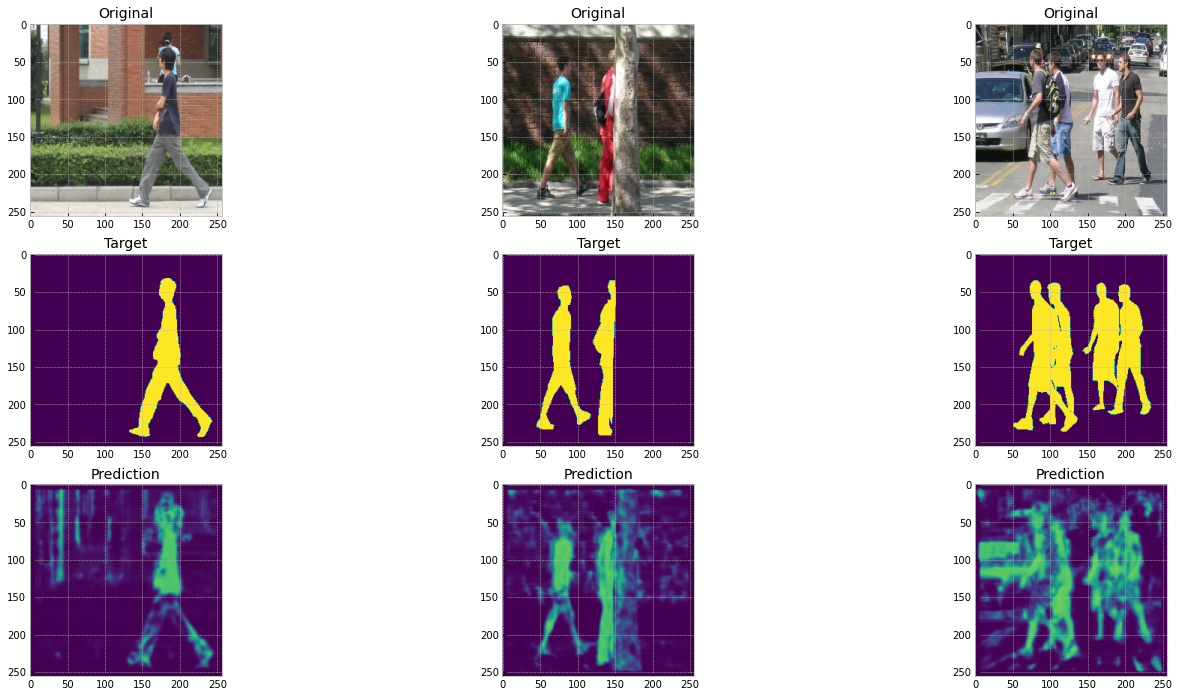

In [6]:
with TorchDeviceSession(global_torch_device("cpu"), model):
    with torch.no_grad():
        with TorchCacheSession():
            with TorchEvalSession(model):
                valid_masks = []
                out_data = []

                probabilities = []
                for sample_i, (data, target) in enumerate(lo):
                    data = data.to(global_torch_device())
                    outpu, *_ = model(data)
                    for m, d, p in zip(
                        target.cpu().detach().numpy(),
                        data.cpu().detach().numpy(),
                        torch.sigmoid(outpu).cpu().detach().numpy(),
                    ):
                        out_data.append(cv2_resize(chw_to_hwc(d), a))
                        valid_masks.append(cv2_resize(m[0], a))
                        probabilities.append(cv2_resize(p[0], a))
                        sample_i += 1

                        if sample_i >= tr - 1:
                            break

                    if sample_i >= tr - 1:
                        break

                min_a = min(3, len(out_data))
                f, ax = pyplot.subplots(min_a, 3, figsize=(24, 12))

                for i in range(min_a):
                    ax[0, i].imshow(out_data[i], vmin=0, vmax=1)
                    ax[0, i].set_title("Original", fontsize=14)

                    ax[1, i].imshow(valid_masks[i], vmin=0, vmax=1)
                    ax[1, i].set_title("Target", fontsize=14)

                    ax[2, i].imshow(probabilities[i], vmin=0, vmax=1)
                    ax[2, i].set_title("Prediction", fontsize=14)

                pyplot.show()